# 2-Layer Bayesian Neural Network with PyTorch
This notebook trains a 2 layer neural network on the [MNIST digit recognizer set](https://www.kaggle.com/competitions/digit-recognizer/data). The purpose of this notebook is to have a simple starting point to use building a Bayesian neural network using variaional inference.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

## Define Bayesian NN

The class `BayesianNN` defines a fully connected 2-layer Bayesian Neural Network in PyTorch. Instead of fixed weights and biases, each parameter is represented by a probability distribution — specifically, a Normal distribution with trainable mean and standard deviation. This enables the network to model uncertainty through variational inference.

1. Variational Parameters

In the constructor `__init__`, each weight and bias has two associated parameters:
- $ \mu $: the mean of the distribution
- $ \log \sigma $: the log of the standard deviation


2. Sampling Weights

The method `sample_weights()` uses the reparameterization trick to draw samples from each weight’s distribution:
$$
w = \mu + \sigma \cdot \epsilon, \quad \epsilon \sim \mathcal{N}(0, I)
$$

This ensures gradients can flow through the sampling process during backprop.

3. Forward Pass

The method `forward(X, weights)` performs the forward pass of the network:
* Computes the pre-activation of the hidden layer:
   $$
   Z^{(1)} = W^{(1)} X + b^{(1)}
   $$
* Applies ReLU non-linearity:
   $$
   A^{(1)} = \text{ReLU}(Z^{(1)})
   $$
* Computes the output layer:
   $$
   Z^{(2)} = W^{(2)} A^{(1)} + b^{(2)}
   $$
* Applies log-softmax to obtain log-probabilities:
   $$
   A^{(2)} = \log\left( \frac{e^{Z^{(2)}}}{\sum e^{Z^{(2)}}} \right)
   $$

4. KL Divergence

The method `kl_divergence()` computes the total KL divergence between each variational posterior $q(w) = \mathcal{N}(\mu, \sigma^2$ and a standard Normal prior $p(w) = \mathcal{N}(0, 1)$:
$$
\text{KL}(q(w) \| p(w)) = \frac{1}{2} \sum \left( \mu^2 + \sigma^2 - 1 - 2\log\sigma \right)
$$

This term is added to the loss during training as a regularizer and is critical to optimizing the variational objective (ELBO).


In [2]:
class BayesianNN(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=128, output_dim=10):
        super().__init__()
        self.W1_mu = nn.Parameter(torch.randn(hidden_dim, input_dim) * 0.1)
        self.W1_log_std = nn.Parameter(torch.full((hidden_dim, input_dim), -3.0))
        self.b1_mu = nn.Parameter(torch.zeros(hidden_dim))
        self.b1_log_std = nn.Parameter(torch.full((hidden_dim,), -3.0))

        self.W2_mu = nn.Parameter(torch.randn(output_dim, hidden_dim) * 0.1)
        self.W2_log_std = nn.Parameter(torch.full((output_dim, hidden_dim), -3.0))
        self.b2_mu = nn.Parameter(torch.zeros(output_dim))
        self.b2_log_std = nn.Parameter(torch.full((output_dim,), -3.0))

    def sample_weights(self):
        weights = {}
        for name in ['W1', 'b1', 'W2', 'b2']:
            mu = getattr(self, f"{name}_mu")
            log_std = getattr(self, f"{name}_log_std")
            std = torch.exp(log_std)
            eps = torch.randn_like(std)
            weights[name] = mu + std * eps
        return weights

    def forward(self, X, weights=None):
        if weights is None:
            weights = self.sample_weights()
    
        Z1 = F.linear(X, weights['W1'], weights['b1'])
        A1 = F.relu(Z1)
        Z2 = F.linear(A1, weights['W2'], weights['b2'])
        return F.log_softmax(Z2, dim=1)


    def kl_divergence(self):
        kl = 0
        for name in ['W1', 'b1', 'W2', 'b2']:
            mu = getattr(self, f"{name}_mu")
            log_std = getattr(self, f"{name}_log_std")
            std = torch.exp(log_std)
            kl += 0.5 * torch.sum(std**2 + mu**2 - 1 - 2 * log_std)
        return kl

## Data Loading and Transformation

In [3]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda x: x.view(-1))])
train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BayesianNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

## Training Loop

To train the model we loop over the data from the training set multiple times, each loop is called an epoch. For each epoch we track the total loss.

First we prepare the data by flattening the images so they match the input size of the neural network. The gradients are then (re)set to zero.

We then use the reparametrization trick to sample weights. 
$$
w = \mu + \sigma \cdot \epsilon, \quad \epsilon \sim \mathcal{N}(0,I) 
$$
Here, a new sample of the network's neights are drawn from each parameter's posterior distribution.

Next we do a forward pass which results in the log-probabilities for each class. 
$$
\mathbf{Z}^{(1)} = \mathbf{W}^{(1)}\mathbf{X} + \mathbf{b}^{(1)} \quad \to \quad \mathbf{A}^{(1)} = \text{ReLU}(\mathbf{Z}^{(1)}) 
$$
$$
\mathbf{Z}^{(2)} = \mathbf{W}^{(2)}\mathbf{A}^{(1)} + \mathbf{b}^{(2)} \quad \to \quad \mathbf{A}^{(2)} = \log\text{-softmax}(\mathbf{Z}^{(2)})
$$
The negative log likelihood is calculated to meausre how well the predictions from the model machine the ground truth
$$
\text{NLL} \approx -\sum_i \log p(\text{label}_i \mid \mathbf{x}_i; w)
$$

KL divergence is then calculated as 
$$
\text{KL}(q(w) \| p(w)) \;=\; \frac{1}{2} \sum\big(\mu^2 + \sigma^2 - 1 - 2\log\sigma\big)
$$
using the variational posterior $q(w)$ and prior $p(w)$. This is added to regularize against the prior.

The total loss is calculated, which when we minimise is the same as maximizing the ELBO. After this we do the backwards pass and optimize the parameters for the model.

In [5]:
import torch
import torch.nn.functional as F

model.train()
for epoch in range(20):
    total_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        data = data.view(data.size(0), -1)
        optimizer.zero_grad()
        weights = model.sample_weights()
        
        output = model(data, weights)
        
        nll = F.nll_loss(output, target)
        kl = model.kl_divergence() / len(train_loader.dataset)
        loss = nll + kl
        
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    
    print(f"Epoch {epoch + 1}, Loss: {total_loss:.4f}") 

Epoch 1, Loss: 4019.2816
Epoch 2, Loss: 3069.7259
Epoch 3, Loss: 2386.4645
Epoch 4, Loss: 1967.1130
Epoch 5, Loss: 1751.4059
Epoch 6, Loss: 1598.6106
Epoch 7, Loss: 1476.2723
Epoch 8, Loss: 1374.6620
Epoch 9, Loss: 1286.7060
Epoch 10, Loss: 1210.8113
Epoch 11, Loss: 1143.1947
Epoch 12, Loss: 1083.9078
Epoch 13, Loss: 1028.1940
Epoch 14, Loss: 976.1795
Epoch 15, Loss: 933.4408
Epoch 16, Loss: 891.0937
Epoch 17, Loss: 856.4808
Epoch 18, Loss: 821.4742
Epoch 19, Loss: 788.4265
Epoch 20, Loss: 758.5482


## Model Evaluation 

The function `evaluate(model, test_loader, samples=10)` performs Bayesian evaluation of the trained model. Unlike standard evaluation where predictions are made using a fixed set of weights, we sample multiple weight configurations from the learned variational posterior and average the predictions. This reflects model uncertainty in the final prediction.

We first draw multiple sampels of the network weights and make the predictions. Then after we get all the samples we compute the mean predicted probabilites and pick the class with the highest value.

For each batch the predicted class is compared to the ground truth and then we use this to compute the total accuracy.

In [6]:
test_data = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_data, batch_size=1000, shuffle=False)

In [7]:
def evaluate(model, test_loader, samples=10):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            
            data = data.view(data.size(0), -1)

            probs_sum = torch.zeros(data.size(0), 10).to(device)
            
            for _ in range(samples):
                weights = model.sample_weights()
                output = model(data, weights)
                probs_sum += output.exp()

            avg_probs = probs_sum / samples
            
            pred = avg_probs.argmax(dim=1)
            correct += (pred == target).sum().item()
            total += target.size(0)

    accuracy = 100.0 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")

In [8]:
evaluate(model, test_loader, samples=10)

Test Accuracy: 98.15%


## Visualize Model Confidence 

In [9]:
import matplotlib.pyplot as plt
import torch
import scipy.stats


def plot_prediction_confidence(model, test_loader, samples=30):
    model.eval()
    confidences = []

    with torch.no_grad():
        for data, _ in test_loader:
            data = data.to(device)
            probs_sum = torch.zeros(data.size(0), 10).to(device)

            for _ in range(samples):
                weights = model.sample_weights()
                output = model(data, weights)
                probs_sum += output.exp()

            avg_probs = probs_sum / samples
            max_conf = avg_probs.max(dim=1).values
            confidences.extend(max_conf.cpu().numpy())

    plt.hist(confidences, bins=20, range=(0, 1), color='steelblue', edgecolor='black')
    plt.title("Prediction Confidence Distribution")
    plt.xlabel("Max Predicted Probability")
    plt.ylabel("Number of Samples")
    plt.grid(True)
    plt.show()

def plot_entropy_distribution(model, test_loader, samples=30):
    model.eval()
    entropies = []

    with torch.no_grad():
        for data, _ in test_loader:
            data = data.to(device)
            probs_sum = torch.zeros(data.size(0), 10).to(device)

            for _ in range(samples):
                weights = model.sample_weights()
                output = model(data, weights)
                probs_sum += output.exp()

            avg_probs = (probs_sum / samples).cpu().numpy()
            entropy = scipy.stats.entropy(avg_probs.T)  # shape: (batch,)
            entropies.extend(entropy)

    plt.hist(entropies, bins=30, color='darkorange', edgecolor='black')
    plt.title("Predictive Entropy Distribution")
    plt.xlabel("Entropy")
    plt.ylabel("Number of Samples")
    plt.grid(True)
    plt.show()

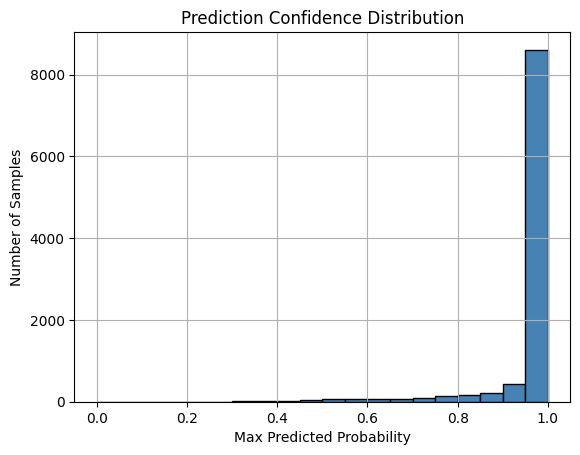

In [10]:
plot_prediction_confidence(model, test_loader, samples=30)

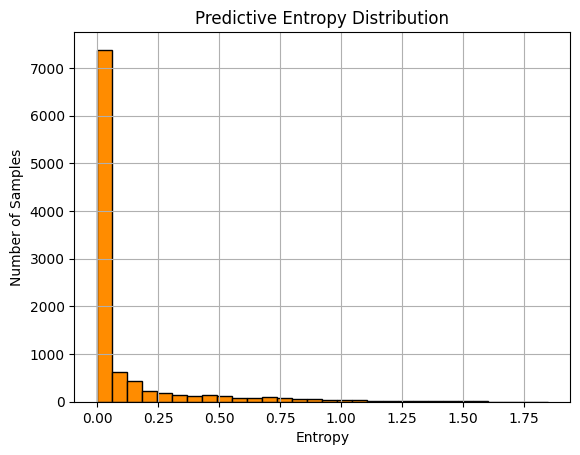

In [11]:
plot_entropy_distribution(model, test_loader, samples=30)

## View Predictions

In [12]:
import torch
import matplotlib.pyplot as plt
import scipy.stats

def test_prediction(index, model, test_dataset, num_samples=30):
    model.eval()

    image, label = test_dataset[index]
    image = image.view(1, -1).to(device)  # shape: (1, 784)

    probs_sum = torch.zeros((1, 10)).to(device)
    with torch.no_grad():
        for _ in range(num_samples):
            weights = model.sample_weights()
            output = model(image, weights)  # log-probs
            probs_sum += output.exp()       # convert to probs

    avg_probs = probs_sum / num_samples
    entropy = scipy.stats.entropy(avg_probs.cpu().numpy()[0], base=2)
    prediction = torch.argmax(avg_probs, dim=1).item()

    print("Prediction:", prediction)
    print("Label:     ", label)
    print("Entropy:   {:.4f}".format(entropy))

    img = image.view(28, 28).cpu().numpy() * 255
    plt.gray()
    plt.imshow(img, interpolation='nearest')
    plt.show()

Prediction: 7
Label:      7
Entropy:   0.0029


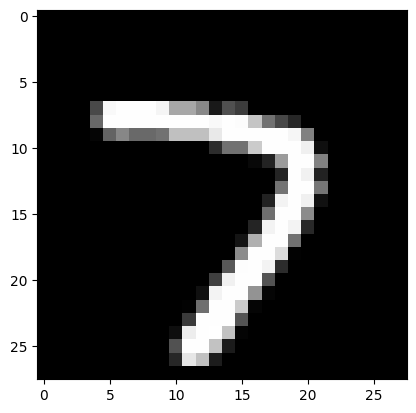

In [13]:
test_prediction(index=17, model=model, test_dataset=test_data, num_samples=30)

Prediction: 2
Label:      2
Entropy:   0.0010


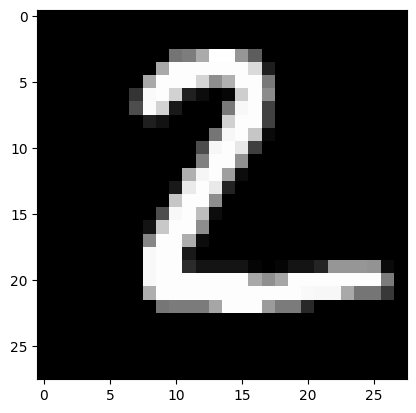

In [14]:
test_prediction(index=1, model=model, test_dataset=test_data, num_samples=30)

## Visualize Prediction Confidence

In [15]:
import torch

def predict_with_uncertainty(model, x, n_iter=100):
    model.train()  
    preds = []
    for _ in range(n_iter):
        pred = model(x)
        preds.append(pred.unsqueeze(0))
    preds = torch.cat(preds, dim=0)
    mean_prediction = preds.mean(dim=0)
    std_prediction = preds.std(dim=0)
    return mean_prediction, std_prediction


In [16]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def visualize_prediction_uncertainty(image, mean_pred, std_pred, true_label=None):
    probs = torch.softmax(mean_pred, dim=0).detach().cpu().numpy()

    errors = std_pred.detach().cpu().numpy()

    errors = np.clip(errors, 0.0, 0.25)

    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    if image.dim() == 3 and image.shape[0] == 1:
        image = image.squeeze(0)
    axs[0].imshow(image, cmap='gray')
    axs[0].set_title("Input Image")
    axs[0].axis("off")

    x = np.arange(len(probs))
    axs[1].bar(x, probs, yerr=errors, capsize=5)
    axs[1].set_xticks(x)
    axs[1].set_ylim([0, 1])  
    axs[1].set_xlabel("Classes")
    axs[1].set_ylabel("Predicted Probability")
    title = "Predictive Uncertainty"
    if true_label is not None:
        title += f" (True label: {true_label})"
    axs[1].set_title(title)

    plt.tight_layout()
    plt.show()


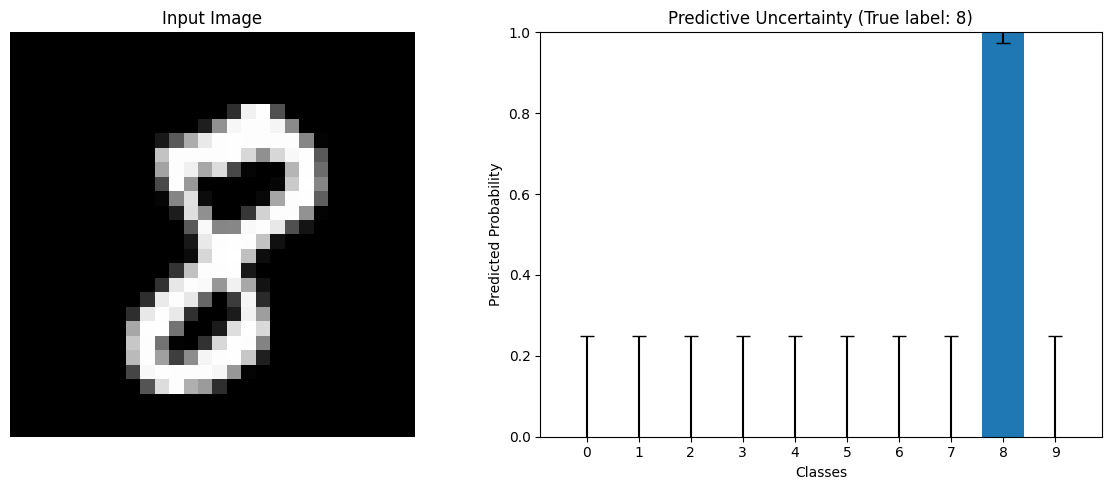

In [18]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

transform = transforms.ToTensor()
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)

sample, label = next(iter(test_loader))

sample_flat = sample.view(sample.size(0), -1)

mean_pred, std_pred = predict_with_uncertainty(model, sample_flat, n_iter=100)

visualize_prediction_uncertainty(
    image=sample[0],
    mean_pred=mean_pred[0],
    std_pred=std_pred[0],
    true_label=label.item()
)
